## Informações do dataset
Usuários:
Contém os usuários. Observe que os IDs de usuário (User-ID) foram anonimizados e mapeados para números inteiros. Os dados demográficos são fornecidos (localização, idade), se disponíveis. Caso contrário, esses campos conterão valores NULL.

Livros:
Os livros são identificados pelo respectivo ISBN. ISBNs inválidos já foram removidos do conjunto de dados. Além disso, são fornecidas algumas informações baseadas em conteúdo (título do livro, autor do livro, ano de publicação, editora), obtidas na Amazon Web Services. Observe que no caso de vários autores, apenas o primeiro é fornecido. URLs com links para imagens de capa também são fornecidos, aparecendo em três sabores diferentes (Image-URL-S, Image-URL-M, Image-URL-L), ou seja, pequeno, médio, grande. Esses URLs apontam para o site da Amazon.

Avaliações:
Contém as informações de classificação do livro. As classificações (Book-Rating) podem ser explícitas, expressas numa escala de 1 a 10 (valores mais elevados denotam maior apreciação), ou implícitas, expressas por 0.


# Projeto de Realizar recomendações de livros 

Aluno: Paulo Victor Fonseca Sousa

Matricula:211043718

Github:PauloVictorFS

## Introdução
O projeto a seguir tem como objetivo explorar o aprendizado de máquina aplicado à Filtros colaborativos A tarefa principal será Treinar um modelo capaz de realizar recomendações de livros a um usuário.
Critérios do projeto:
Propósito: O projeto tem como propósito principal a criação de um Recomendador de livros
Tema Abordado na Lição: O projeto está alinhado com os conceitos e técnicas apresentados na lição do Fastai relacionada a filtros colaborativos

Dado Coerente com o Tema e Aquisição do dado: Os dados utilizados para auxiliar a criação da rede foram encontrados no Kaggle:  Book Recommendation Dataset (https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)


Organização: O projeto é organizado em células de código que executam tarefas específicas, desde a aquisição de dados até a criação, treinamento e avaliação. Isso proporciona uma estrutura clara para compreender o fluxo de trabalho. Cada célula será explicada de forma detalhada

Jupyter: O projeto é elaborado usando um ambiente Kaggle, o que permite documentar as etapas do projeto e executar código interativamente.

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import os
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/Books.csv
/kaggle/input/book-recommendation-dataset/recsys_taxonomy2.png


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/book-recommendation-dataset')
else:
    import zipfile,kaggle
    path = Path('book-recommendation-dataset')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

books = pd.read_csv(path/'Books.csv')
ratings = pd.read_csv(path/'Ratings.csv')
users = pd.read_csv(path/'Users.csv')

/tmp/ipykernel_47/3272636161.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(path/'Books.csv')


# Análise Dos Dados

Durante essa etapa será analisado o dataset, mostrando informações sobre o csv books, ratings e users, verificando quais são vazios e a estrutura do dataset

In [4]:
books.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [5]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [8]:
import numpy as np

ratings.describe(include=(np.number))


,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [9]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

# Construindo o  Filtro Colaborativo

Nessa etapa construiremos o filtro colaborativo, para isso precisaremos mesclar as tabelas para a criação do dataloader

In [11]:
ratings = ratings.merge(books)
ratings.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg


Também observaremos um dos usuários e o rating dos livros que ele leu

In [12]:
merged_df = ratings.merge(books)

# Filtrar e imprimir todas as linhas com User-ID 276725
user_276725_info = merged_df[merged_df['User-ID'] ==2313]
print(user_276725_info)

        User-ID        ISBN  Book-Rating  \
1          2313  034545104X            5   
5784       2313  0812533550            9   
9029       2313  0679745580            8   
39443      2313  0060173289            9   
51202      2313  0385482388            5   
129253     2313  0399146431            5   
137010     2313  0345348036            9   
188546     2313  0553278223            7   
230648     2313  0449912558            0   
260971     2313  0020442602            9   
261006     2313  0295955252            8   
261008     2313  0300069049            0   
261009     2313  0312186754            5   
261011     2313  0312275560            6   
261012     2313  0312876513            6   
261026     2313  0375706771            0   
261406     2313  0385470142            9   
261408     2313  0394756827           10   
261418     2313  0395874653            8   
261419     2313  0399141146            3   
261502     2313  0451525078            0   
261511     2313  0452260116     

Agora, Será criado um objeto DataLoaders dessa tabela. Por padrão,as colunas User-ID, ISBN 	e Book-Rating serão utilizadas para produzir o objeto.

O objeto data_loader é uma instância da classe CollabDataLoaders fornecida pelo Fastai, que facilita a criação de DataLoaders para o treinamento e validação de modelos de filtragem colaborativa. Este tipo de modelo é comumente usado em sistemas de recomendação.

A função from_df da classe CollabDataLoaders é utilizada para criar este objeto a partir do conjunto de dados de avaliações (ratings). O parâmetro item_name='Book-Title' é crucial porque indica a coluna no conjunto de dados de avaliações que contém os nomes dos itens (itens a serem recomendados). Esta informação é essencial para que o modelo saiba como identificar cada item durante o treinamento.


In [51]:
data_loader = CollabDataLoaders.from_df(ratings, item_name='Book-Title')
data_loader.show_batch()
merged_df.to_csv('merged_dataset.csv', index=False)

,User-ID,Book-Title,Book-Rating
0,69180,The Perfect Storm : A True Story of Men Against the Sea,0
1,267387,All Around the Town,0
2,200315,"Chapterhouse Dune (Dune Chronicles, Book 6)",0
3,98789,Pobby and Dingan,8
4,123203,Silent Honor,0
5,175052,The Phantom of Manhattan,7
6,258185,Improper English,9
7,152186,Fall from Grace,0
8,230522,The Gospel of Corax: A Novel,0
9,147965,Good Faith,0


As variáveis n_users e n_books estão sendo definidas para armazenar o número de usuários e livros no conjunto de dados, respectivamente. Esses valores são obtidos utilizando a função len() aplicada às colunas relevantes dos DataLoaders (data_loader.classes[coluna]), que fornece as classes associadas a cada coluna. Isso é importante para dimensionar corretamente o modelo de filtragem colaborativa.

In [14]:
n_users = len(data_loader.classes['User-ID'])
n_books = len(data_loader.classes['Book-Title'])
n_factors = 5

Após isso é apresentado a definição de uma classe chamada DotProductBias, que herda da classe Module do módulo torch.nn do PyTorch. Esta classe é projetada para representar um modelo de filtragem colaborativa com viés, com o objetivo de fazer recomendações de itens (livros, neste caso) para usuários.

A classe DotProductBias é inicializada no método __init__ com os seguintes parâmetros:

n_users: Número de usuários no conjunto de dados.
n_books: Número de livros no conjunto de dados.
n_factors: Número de fatores latentes a serem utilizados (definido como 5).
y_range: Intervalo de valores esperados para as previsões do modelo.
Dentro do método __init__, são definidas camadas de incorporação (Embedding) para representar os usuários e os livros, bem como parâmetros adicionais para representar os viéses dos usuários e livros.

O método forward() realiza a passagem direta do modelo. O tensor de entrada x contém os índices dos usuários e livros. Os fatores latentes correspondentes a esses índices são obtidos utilizando as camadas de incorporação para usuários (users) e livros (books). A previsão parcial é então calculada através do produto escalar desses fatores latentes, e os viéses dos usuários e livros são adicionados para personalizar as previsões de acordo com os padrões específicos de cada usuário e livro.

In [15]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 10.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.book_factors = Embedding(n_books, n_factors)
        self.book_bias = Embedding(n_books, 1)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        books = self.book_factors(x[:,1])
        res = (users * books).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.book_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Após isso uma instância do modelo DotProductBias é criada com base no número de usuários, número de livros e 50 fatores latentes. Em seguida, um objeto Learner é criado utilizando os dados de treinamento, o modelo recém-criado e a função de perda MSELossFlat. A função fit_one_cycle é aplicada para treinar o modelo por 10 épocas, com uma taxa de aprendizagem inicial de 5e-3 e Sem peso de decaimento . O peso de decaimento é utilizado para penalizar pesos maiores, incentivando a rede neural a manter pesos menores, porém ele piorava o modelo.

In [16]:
model = DotProductBias(n_users, n_books, n_factors)
learn_dot = Learner(data_loader, model, loss_func=MSELossFlat())
learn_dot.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,time
0,13.549620,13.364043,01:41
1,11.607655,11.911374,01:42
2,11.124716,11.939549,01:38
3,10.463046,12.092199,01:38
4,10.365561,12.205770,01:37
5,9.844447,12.285366,01:37
6,9.256183,12.351643,01:37
7,8.718152,12.400423,01:37
8,8.483231,12.429401,01:36
9,8.480520,12.434698,01:37


# Utilizando Deep learning

In [17]:
embs = get_emb_sz(data_loader)
embs

[(81473, 600), (241072, 600)]

A classe CollabNN  utiliza redes neurais.

No método __init__, são definidos os atributos da classe. user_sz e item_sz são tuplas que contêm o número de usuários e itens no conjunto de dados, respectivamente, além da dimensão dos fatores latentes para usuários e itens. O intervalo y_range especifica os valores esperados das previsões do modelo, enquanto n_act determina o número de neurônios na camada oculta da rede neural.

Em seguida, são criadas as camadas de incorporação (embedding) para representar os usuários e itens. A camada de incorporação para os usuários tem uma dimensão de acordo com user_sz, e a camada de incorporação para os itens tem dimensão de acordo com item_sz.

A rede neural é definida usando a classe nn.Sequential, que permite empilhar camadas sequencialmente. Ela consiste em uma camada linear de entrada, uma função de ativação ReLU e uma camada linear de saída. A camada linear de entrada recebe as representações concatenadas dos usuários e itens como entrada, enquanto a camada linear de saída produz uma única saída, que é a previsão final do modelo.

No método forward, o tensor de entrada x contém os índices dos usuários e itens. A partir desses índices, são obtidas as representações de incorporação dos usuários e itens correspondentes. Essas representações são então concatenadas ao longo da dimensão 1 para formar um único tensor de entrada para a rede neural.

Esse tensor é passado pelas camadas da rede neural definidas anteriormente, e a saída resultante é aplicada a uma função de ativação sigmoidal. Essa função sigmoidal garante que as previsões estejam dentro do intervalo especificado por y_range. Por fim, as previsões redimensionadas são retornadas como saída do método forward. Resumindo, a classe CollabNN encapsula um modelo de filtragem colaborativa baseado em redes neurais, incorporando características específicas dos usuários e itens para gerar previsões ajustadas.

In [18]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,10.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)


Agora é realizado o treinamento do modelo, que não obteve um resultado positivo, com o valid loss aumentando

In [19]:
model = CollabNN(*embs)
learn = Learner(data_loader, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,11.797328,11.618390,20:22
1,11.047592,11.599441,20:16
2,10.223789,11.804575,20:16
3,9.006161,12.230672,20:15
4,7.565744,12.773348,20:14


# Inferência 

Após montar os modelos, foi  realizado Algumas análises como eles respondem a pedidos de recomendação de usuários. Além disso, uma análise interessante foi realizada para verificar quais parâmetros o modelo aprendeu, e uma maneira mais direta de explorar isso é observar os viéses. 

Abaixo será mostrado os livros com os menores valores no vetor

a variável user_bias_dot recebe o vetor de viés dos usuários, que contém os menores pesos relacionados aos usuários aprendidos pelo modelo. A seguir, os índices desse vetor são classificados em ordem crescente utilizando a função argsort(). Os primeiros cinco índices são selecionados com [:5] e atribuídos à variável idxs_user. Finalmente, é impressa uma lista dos cinco títulos de livros correspondentes aos menores valores de viés do usuário

In [22]:
book_bias_dot = learn_dot.model.book_bias.weight.squeeze()
idxs = book_bias_dot.argsort()[:5]
[data_loader.classes['Book-Title'][i] for i in idxs]


['Wild Animus',
 'And Then There Were None : A Novel',
 'Getting Lucky (Avon Light Contemporary Romances)',
 'New Vegetarian: Bold and Beautiful Recipes for Every Occasion',
 'Smart Vs. Pretty']

Será realizado algo parecido para os livros de maiores viés (maiores valores)

In [24]:
idxs = book_bias_dot.argsort(descending=True)[:5]
[data_loader.classes['Book-Title'][i] for i in idxs]

['Free',
 'Love You Forever',
 'Johnny Got His Gun',
 'Preludes and Nocturnes (Sandman, Book 1)',
 'Falling Up']

Após isso será visto de forma mais abrangente um "mapa" dos livros, de tal forma que livros mais próximos são livros semelhantes que devem ser recomendados aos usuários

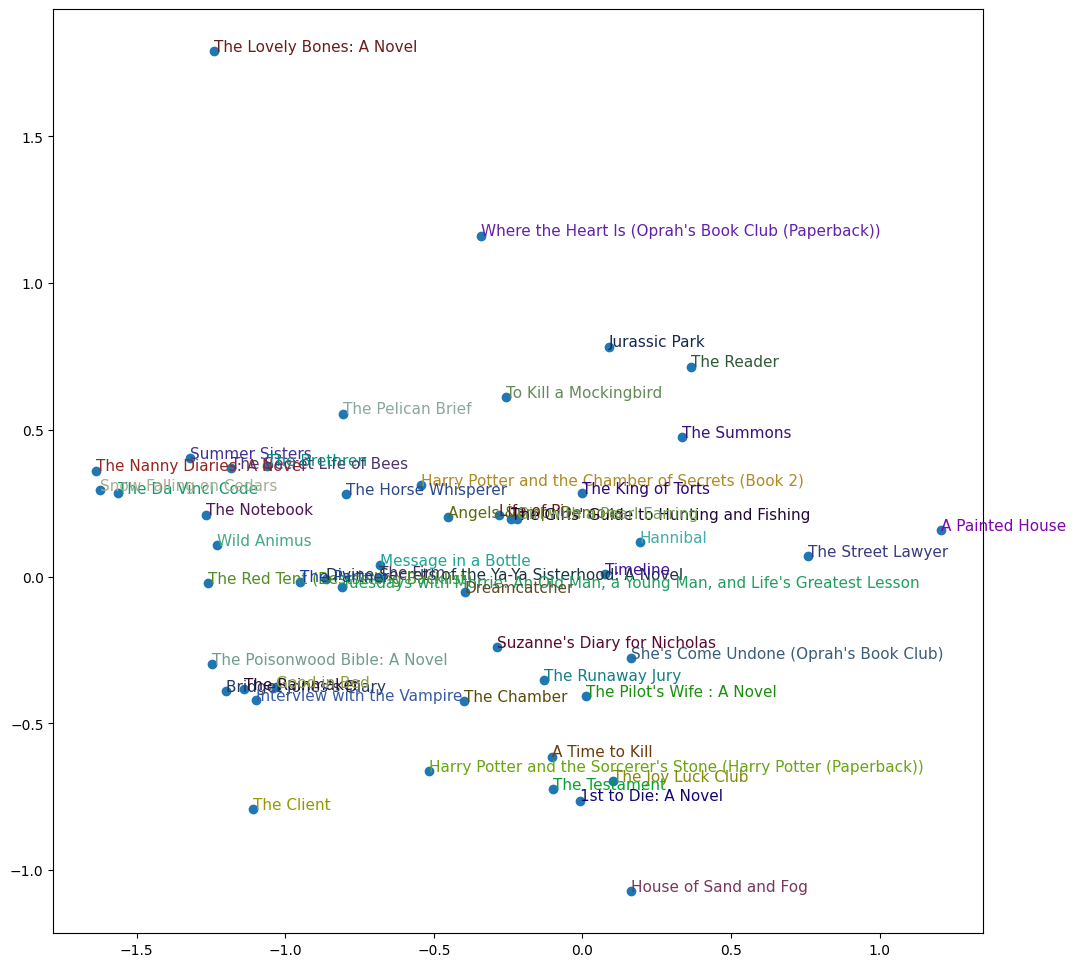

In [25]:
g = ratings.groupby('Book-Title')['Book-Rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn_dot.dls.classes['Book-Title'].o2i[m] for m in top_books])
book_w = learn_dot.model.book_factors.weight[top_idxs].cpu().detach()
book_pca = book_w.pca(3)
fac0,fac1,fac2 = book_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Após isso é realizado um teste com o livro "Hannibal" e é esperado que seja retornado algo no entorno do livro, porém foi retornado o livro 'The Golem and \\the Man Who Was Born Again\\" Two German Supernatural Novels"', demonstrando que o modelo não realizou a recomendação corretamente

In [35]:
books_factors_dot = learn_dot.model.book_factors.weight
idx = data_loader.classes['Book-Title'].o2i['Hannibal']
distances = nn.CosineSimilarity(dim=1)(books_factors_dot, books_factors_dot[idx][None])
idx = distances.argsort(descending=True)[1]
data_loader.classes['Book-Title'][idx]

'The Golem and \\the Man Who Was Born Again\\" Two German Supernatural Novels"'

Após isso, foi realizado outro teste para recomendar o livro a um usuário

Abaixo é um batch do daod de validação Sendo x os livros que  o usuário x avaliou e y as notas que ele deu pra cada livro

In [36]:
x,y = data_loader.valid.one_batch()

Depois foi calculado o erro absoluto

In [39]:
x = x.to('cuda:0')
y = y.to('cuda:0')

preds = learn_dot.forward(x)
result = y-preds
error = abs(result.sum()/len(y))
error

tensor(0.3234, device='cuda:0', grad_fn=<AbsBackward0>)

Aqui foi selecionado os livros do usuário

In [44]:
x[:10]

tensor([[  3225, 186143],
        [ 27737, 230500],
        [ 78557,  70764],
        [  1818, 223861],
        [ 74396, 226401],
        [  9267,  30030],
        [  7100, 210181],
        [ 10463, 205805],
        [ 34062, 191062],
        [ 39901, 145292]], device='cuda:0')

Aq a classificação que foi dada a cada livro

In [45]:
y[:15]

tensor([[7],
        [6],
        [0],
        [0],
        [7],
        [0],
        [8],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0', dtype=torch.int8)

Por fim a predição do modelo para cada exemplo, que gerou uma mudança bem pequena ( de aproximadamente 2 pra cima ou pra baixo da nota que o usuário deu) para cada predição

In [47]:
preds[:15]

tensor([[5.5164e+00],
        [5.0216e+00],
        [2.6413e+00],
        [2.3695e+00],
        [9.0235e+00],
        [1.7778e+00],
        [4.8341e+00],
        [2.7628e-05],
        [4.0857e+00],
        [1.4177e-01],
        [3.0011e+00],
        [2.0788e+00],
        [3.8016e+00],
        [6.4584e+00],
        [3.6315e+00]], device='cuda:0', grad_fn=<SliceBackward0>)

Após isso foi exportado o modelo para ser enviado ao hugging face, cujo link está [aqui](https://huggingface.co/spaces/Srpaulo122/Book_Recommendation)

In [49]:
learn.export('model.pkl')